<a href="https://colab.research.google.com/github/fares-3adi/FraudDetectionProject/blob/main/CS3IP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Credit Card Fraud Detection Using Machine Learning**

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

## Dataset

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Link to Dataset: https://www.openml.org/search?type=data&status=active&id=42175

Citations:
Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon

Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE

Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)

Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Ael; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier

Carcillo, Fabrizio; Le Borgne, Yann-Ael; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

Bertrand Lebichot, Yann-Ael Le Borgne, Liyun He, Frederic Oble, Gianluca Bontempi Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection, INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78-88, 2019

Fabrizio Carcillo, Yann-Ael Le Borgne, Olivier Caelen, Frederic Oble, Gianluca Bontempi Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection Information Sciences, 2019.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Loading the dataset directly from google drive to avoid
# not fully loading it
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Colab/CS3IP/creditcard.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


For reference: The column names are Time, V1 ... V28, Amount, and Class

# **Exploratory Data Analysis**

## Histogram

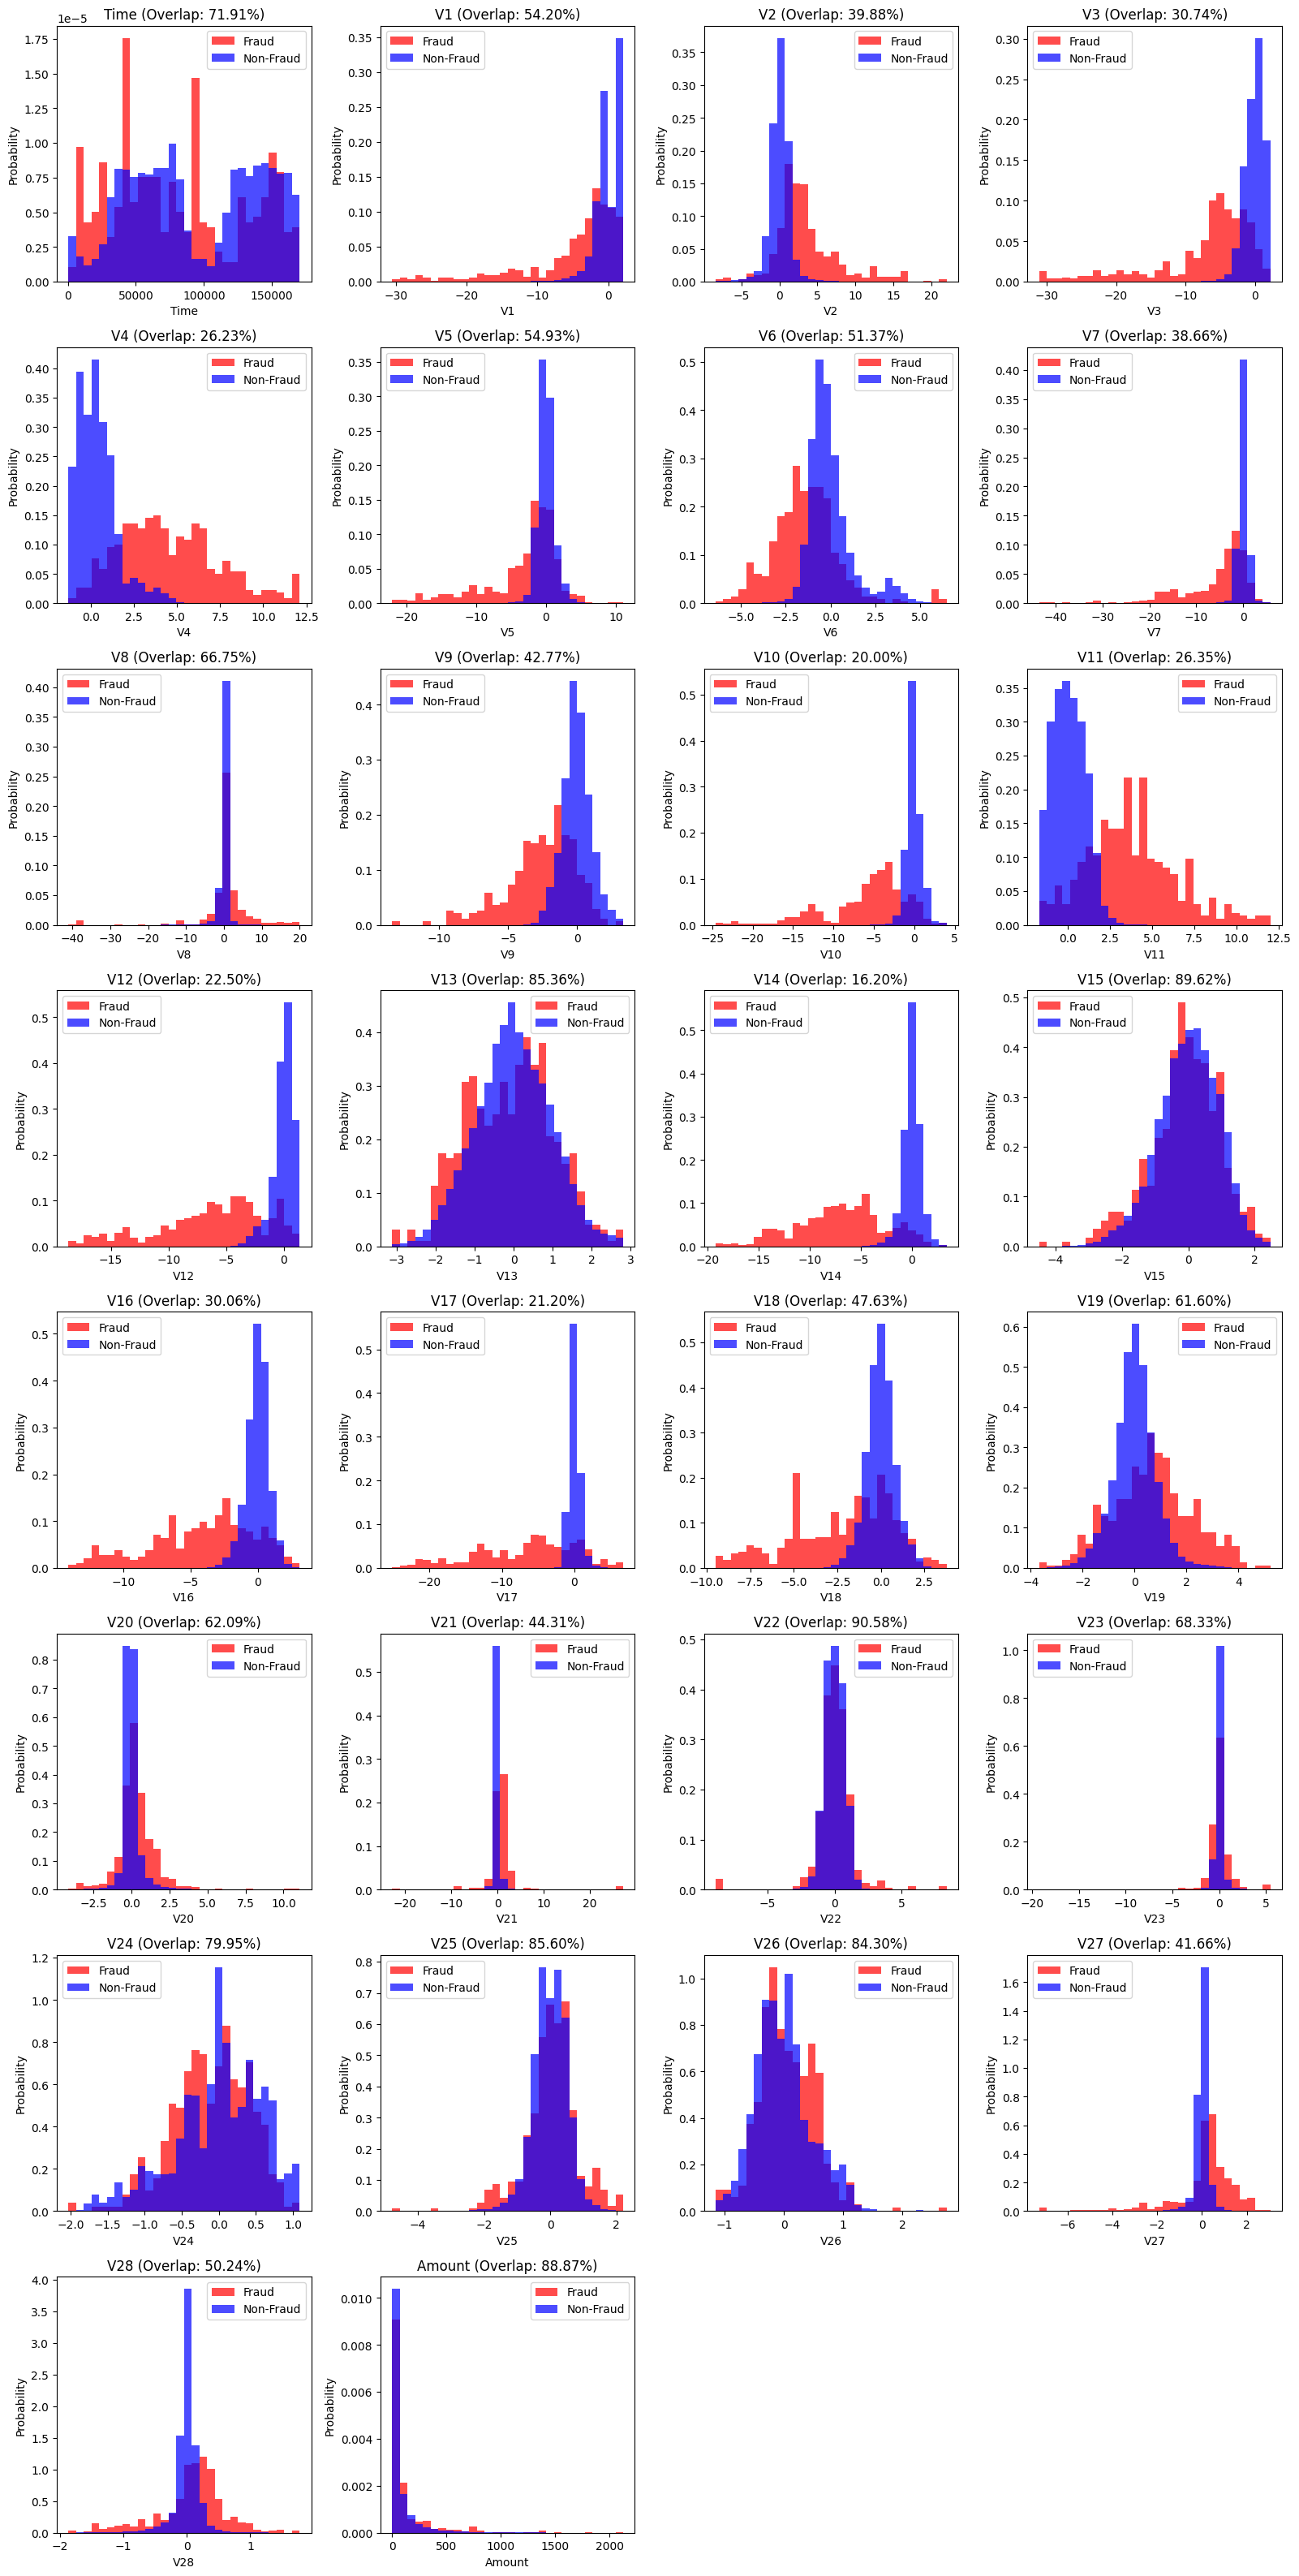

In [ ]:
# Plotting a histogram for each label (fraud and non-fraud)
# To facilitate data analysis for the effect of features on the label
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate percentage overlap
def calculate_overlap(hist1, hist2, bin_widths):
    # Multiply the minimum values by bin widths to account for probability density
    overlap_area = np.sum(np.minimum(hist1, hist2) * bin_widths)
    return overlap_area * 100  # Convert to percentage

# Plotting histograms with percentage overlaps
num_cols = len(df.columns) -1 # Get number of columns except the Class label
num_rows = (num_cols + 3) // 4  # Calculate rows to fit in 4 column grid

plt.figure(figsize=(16, 4*num_rows))  # Adjust figure height for calculated rows


for i, label in enumerate(df.columns[:-1], 1):  # Exclude the 'Class' column
    plt.subplot(num_rows, 4, i)

    # Create histograms for fraud and non-fraud
    fraud_data, bins = np.histogram(df[df["Class"] == 1][label], bins=30, density=True)
    non_fraud_data, _ = np.histogram(df[df["Class"] == 0][label], bins=bins, density=True)

    # Calculate bin widths
    bin_widths = np.diff(bins)

    # Calculate overlap
    overlap_percentage = calculate_overlap(fraud_data, non_fraud_data, bin_widths)

    # Plot histograms
    plt.hist(df[df["Class"] == 1][label], bins=bins, color="red", alpha=0.7, density=True, label="Fraud")
    plt.hist(df[df["Class"] == 0][label], bins=bins, color="blue", alpha=0.7, density=True, label="Non-Fraud")

    # Add title with percentage overlap
    plt.title(f"{label} (Overlap: {overlap_percentage:.2f}%)")
    plt.ylabel("Probability")
    plt.xlabel(label)
    plt.legend()

plt.tight_layout()
plt.show()



### **Analyzing Overlap for Feature Selection**

**Note**: The overlap percentage displayed on top of each histogram shows the percentage by which the two classes overlap for that given feature. A lower percentage overlap indicates a greater divide between the two classes given a classification based on that feature.

**The aim here is to look for the following categories of features:**
- Features with an overlap of over 60% would indicate low discriminative power and would therefore be dopped.
- Features with an overlap under 40% would indicate high discriminative power and would therefore be retained.
- Features with an overlap in the middle range of 40-60% would require further analysis in order to determine whether they should be dropped or retained.

**Observing the results:**

Features with an overlap of 40% or below are (To Be Retained):
- V2 (39.88%)
- V3 (30.74%)
- V11 (26.35%)
- V12 (22.50%)
- V14 (16.20%)
- V16 (30.06%)
- V17 (21.20%)
- V27 (41.66%)


Features with an overlap above 60% (To Be Dropped):
- V8 (66.75%)
- V15 (89.62%)
- V21 (90.58%)
- V22 (85.60%)
- V24 (79.95%)
- V25 (85.60%)
- V26 (84.30%)

Features needing further analysis (Using Random Forest):
- V1 (54.20%)
- V6 (51.37%)
- V9 (42.77%)
- V28 (50.24%)



## Random Forest Feature Importance (Further Feature Analysis)
Further analysis for the features V1, V6, V9, V28

(Features found to have an overlap percentage in the mid range of 40-60%)

Feature Importances:
 V9     0.352203
V6     0.249517
V1     0.230323
V28    0.167957
dtype: float64


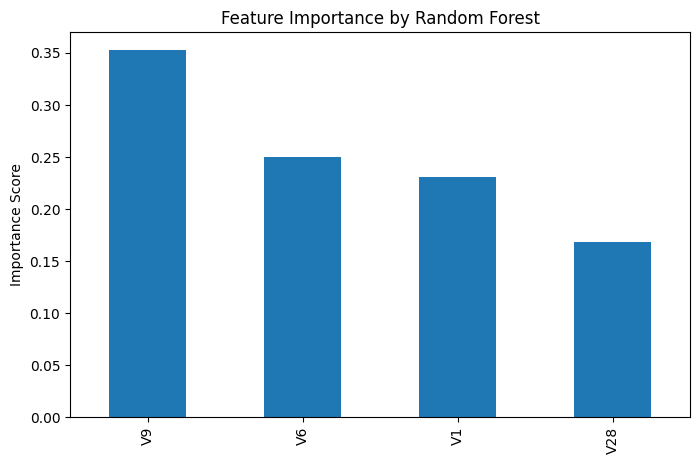

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

# Specify the features and target
X = df[['V1', 'V6', 'V9', 'V28']]
y = df['Class']

# Train a Random Forest model
rf = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf.fit(X, y)

# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Print and visualize feature importances
print("Feature Importances:\n", feature_importances)

# Plot feature importances
feature_importances.plot(kind='bar', figsize=(8, 5), title="Feature Importance by Random Forest")
plt.ylabel("Importance Score")
plt.show()


Based on these results, with each feature scoring an importance score of > 0.1, all these features would be retained.


**-> Actionable: Drop Features V8, V15, V21, V22, V24, V25, V26**

---


## Outlier Detection and Handling (For Time and Amount Column)


## Box Plots & Interquartile Method for Outlier Detection

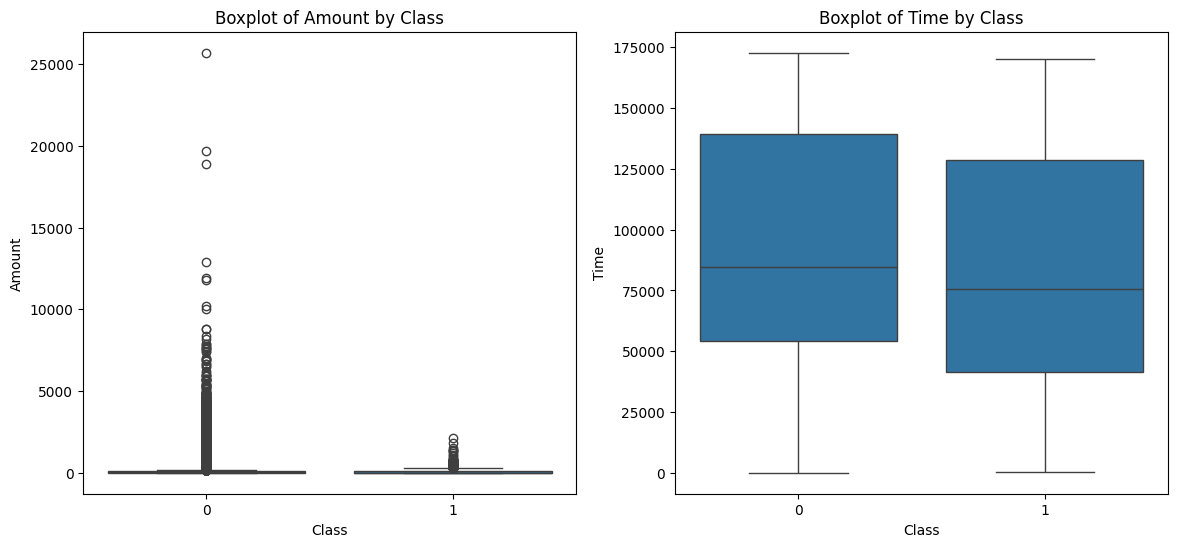

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Class', y='Amount', data=df)
plt.title("Boxplot of Amount by Class")

plt.subplot(1, 2, 2)
sns.boxplot(x='Class', y='Time', data=df)
plt.title("Boxplot of Time by Class")
plt.show()

The above boxplot shows a large number of outliers in the Amount Column for both classes. This could also be discerned from observing the Amount column's histogram which was highly skewed.


**-> Actionable: Apply log transformation to Amount Column (After that the Amount column is Normalized).**


### Interquartile Method (IQR) For Outlier Detection

In [ ]:
# Detect and handle outliers using IQR
for column in ['Amount', 'Time']:  # Analyze 'Amount' and 'Time'
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Define the 'outliers' variable for the current column
  outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

  # Check fraud cases among outliers
  fraud_outliers = outliers[outliers['Class'] == 1]
  print(f"Outliers in {column}: {len(outliers)}")
  print(f"Fraud cases among outliers in {column}: {len(fraud_outliers)}")

  # Optionally cap outliers
  #df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)



Outliers in Amount:
            Time        V1        V2        V3        V4        V5        V6  \
2            1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
20          16.0  0.694885 -1.361819  1.029221  0.834159 -1.191209  1.309109   
51          36.0 -1.004929 -0.985978 -0.038039  3.710061 -6.631951  5.122103   
64          42.0 -0.522666  1.009923  0.276470  1.475289 -0.707013  0.355243   
85          55.0 -4.575093 -4.429184  3.402585  0.903915  3.002224 -0.491078   
...          ...       ...       ...       ...       ...       ...       ...   
284735  172727.0 -1.661169 -0.565425  0.294268 -1.549156 -2.301359  2.365956   
284748  172738.0  1.634178 -0.486939 -1.975967  0.495364  0.263635 -0.713049   
284753  172743.0  1.465737 -0.618047 -2.851391  1.425282  0.893893 -0.958325   
284757  172745.0 -1.757643 -0.982659  1.091540 -1.409539 -0.662159  0.046930   
284806  172792.0 -0.533413 -0.189733  0.703337 -0.506271 -0.012546 -0.649617   

              V7   

This output shows 31904 rows flagged as outliers in the Amount column based on the IQR method.

These outliers are transactions with amounts significantly higher than most other transactions (e.g. exceeding the upper whisker in the boxplot above)


For the time column, there is not outlier-specific action needed.

## Visualizing the Class Imbalance

<ipython-input-6-82357388f4e6>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  class_num = pd.value_counts(df["Class"], sort=True)


Percentage of Fraud (Class==1): 99.82725143693798%
Percentage of Non-Fraud (Class==0): 0.1727485630620034%


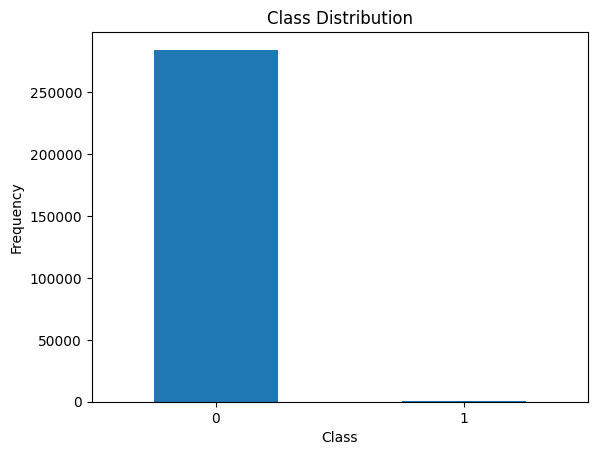

In [ ]:
# Visualizing the split between fraud and non-fraud class
class_num = pd.value_counts(df["Class"], sort=True)
class_num.plot(kind="bar", rot=0)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")

# Checking the percentage of fraud and non-fraud instances
print(f"Percentage of Fraud (Class==1): {df['Class'].value_counts()[0]/len(df) * 100}%")
print(f"Percentage of Non-Fraud (Class==0): {df['Class'].value_counts()[1]/len(df) * 100}%")

The bar chart above shows that fraud class accounts for 492 cases out of the total 284,807 transactions (Indicating a major class imbalance)

Only 0.173% of the dataset contains cases of fraud, while 99.827% is not fraud (values may vary to a few d.p). This means the dataset is heavily skewed/imbalanced and that will need to be dealt with.

**-> Actionable: Oversample the Fraud class and/or undersample the Non-fraud class. Possible use SMOTE.**

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


As can be seen from this sample of the dataset, columns V1 to V28 have been scaled, the only expceptions of scaling being the Time column and the Amount column.

## Summary Statistics Between Fraud and Non-Fraud

Comparing summary statistics between fraud (Class=1) and non-fraud transactions (Class=0) for Time and Amount to detect any distinct patterns that could aid classification

In [ ]:
fraud_data = df[df['Class'] == 1]
non_fraud_data = df[df['Class'] == 0]
print("Fraud Amount Summary:\n", fraud_data['Amount'].describe())
print("----------------------")
print("Non-Fraud Amount Summary:\n", non_fraud_data['Amount'].describe())
print("----------------------")
print("Fraud Time Summary:\n", fraud_data['Time'].describe())
print("----------------------")
print("Non-Fraud Time Summary:\n", non_fraud_data['Time'].describe())

Fraud Amount Summary:
 count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64
----------------------
Non-Fraud Amount Summary:
 count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64
----------------------
Fraud Time Summary:
 count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64
----------------------
Non-Fraud Time Summary:
 count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64


## Correlation Analysis for Key Features

Examining the correlation between Amount, Time, and the principal components (V1 to V28) with the Class label to detect any potential predictive features.
Given that PCA was applied, low correlation between components is expected.

The focus should be on components with noticeable correlation with the Class column.

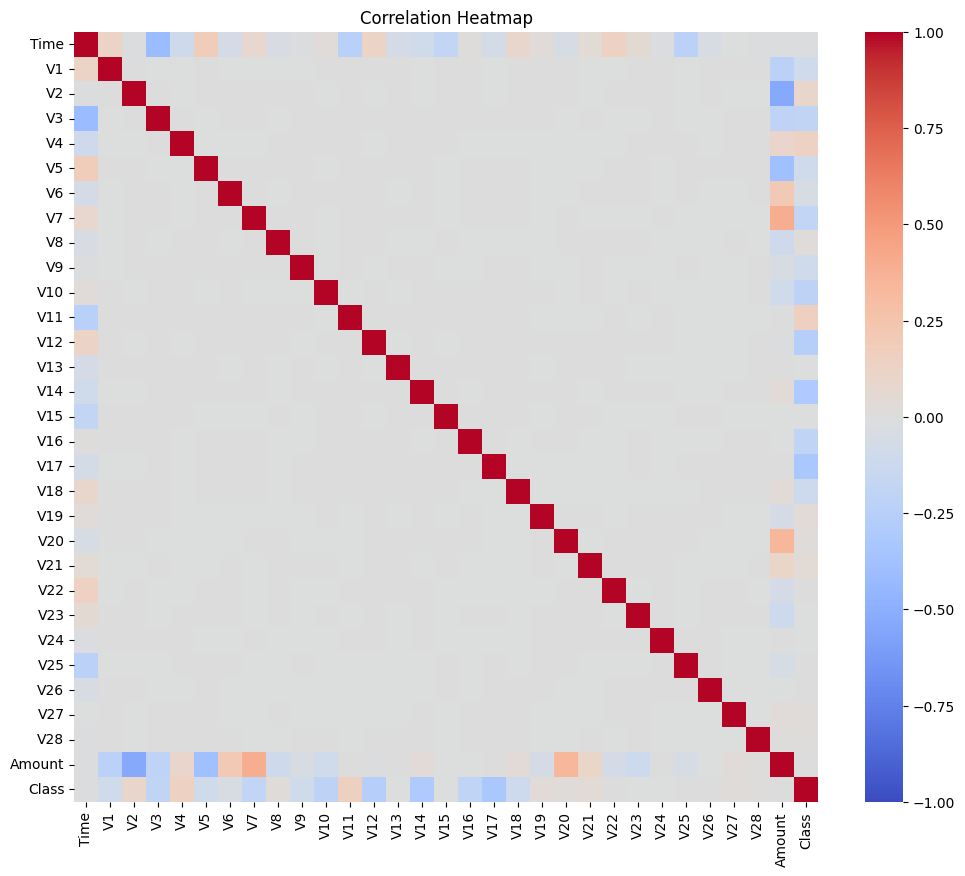

Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
V26       0.004455
V25       0.003308
V22       0.000805
V23      -0.002685
V15      -0.004223
V13      -0.004570
V24      -0.007221
Time     -0.012323
V6       -0.043643
V5       -0.094974
V9       -0.097733
V1       -0.101347
V18      -0.111485
V7       -0.187257
V3       -0.192961
V16      -0.196539
V10      -0.216883
V12      -0.260593
V14      -0.302544
V17      -0.326481
Name: Class, dtype: float64
Highly correlated feature pairs:
 Empty DataFrame
Columns: [level_0, level_1, 0]
Index: []


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the Heat Map
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

print(correlation_matrix['Class'].sort_values(ascending=False))

# Find highly correlated features (e.g., correlation > 0.9)
high_corr_features = correlation_matrix[correlation_matrix > 0.9].stack().reset_index()
high_corr_features = high_corr_features[high_corr_features['level_0'] != high_corr_features['level_1']]
print("Highly correlated feature pairs:\n", high_corr_features)


## Time Based Analysis

Since Time is based on the seconds since the first transaction, plotting the density of transactions over time should help us see if fraud is more prevelent during certain periods.

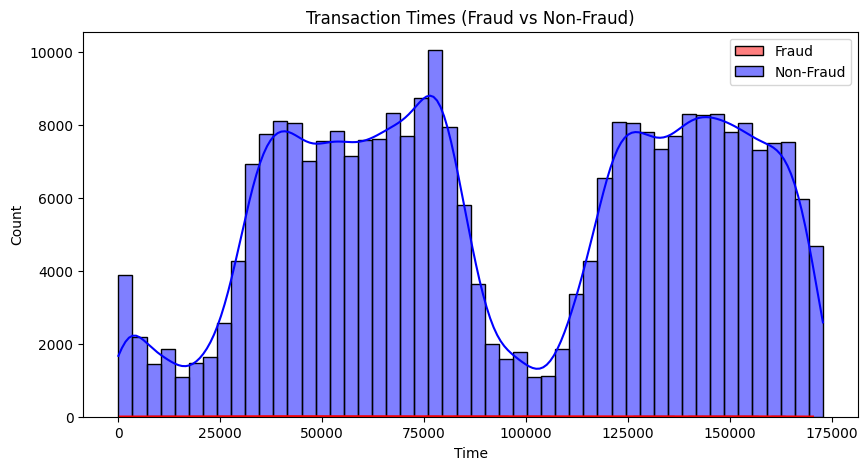

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(fraud_data['Time'], bins=50, color='red', kde=True, label="Fraud")
sns.histplot(non_fraud_data['Time'], bins=50, color='blue', kde=True, label="Non-Fraud")
plt.title("Transaction Times (Fraud vs Non-Fraud)")
plt.xlabel("Time")
plt.legend()
plt.show()


## Transaction Amount Analysis

Exploring if there are distinct patterns in Amount for fraud and non-fraud transactions by visualizing and calculating summary statistics.

For example, fraud might occur more often with lower or higher amounts.




<ipython-input-16-387f79afd2f6>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud_data['Amount'], label="Fraud", shade=True)
<ipython-input-16-387f79afd2f6>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(non_fraud_data['Amount'], label="Non-Fraud", shade=True)


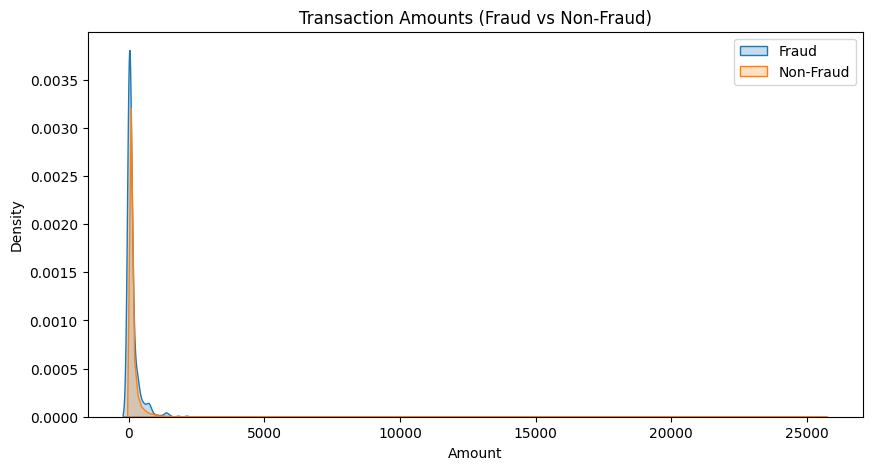

In [ ]:
plt.figure(figsize=(10, 5))
sns.kdeplot(fraud_data['Amount'], label="Fraud", shade=True)
sns.kdeplot(non_fraud_data['Amount'], label="Non-Fraud", shade=True)
plt.title("Transaction Amounts (Fraud vs Non-Fraud)")
plt.xlabel("Amount")
plt.legend()
plt.show()

## Detecting Outliers

Using box plots to detect extreme values in these two features.

Assessing if there are significant outliers in fraud vs. non-fraud transactions and if additional treatment (such as capping) is needed.


## Summing Up Actionables for Data Preprocessing

### Actionables for Data Preprocessing

*  **Actionable 1:** Drop Features V8, V15, V21, V22, V24, V25, V26 **(Feature Selection)**

*  *Intermediate Step: Split dataset into Train, Validation & Test Sets.*

*  **Actionable 2:** Apply log transformation to Amount Column **(Outlier Handling)**

*  **Actionable 3**: Normalize the Amount and Time column **(Scaling Features for consistent ranges)**

*  **Actionable 4:** Oversample the Fraud class and/or undersample the Non-fraud class. Possible use SMOTE.


---

# Data Preprocessing

## Splitting the Dataset and Oversampling
In this step we will split the dataset into a training set, validation set, and testing set

We will then scale the Time and Amount features of the dataset because only the V1 to V28 features are scaled properly

Then we will oversample the training dataset in order to bypass the class imbalance problem discovered from the data analysis above (only 0.173% of the dataset being classified as fraud)


In [ ]:
# Splitting data set into training, validation and testing
training_set, validation_set, testing_set = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
training_set

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
45147,42224.0,-1.970458,-2.391810,1.398453,-3.378710,0.551473,0.070200,-0.058287,0.339251,0.525359,...,-0.000999,0.233310,0.783297,-0.674240,-0.312870,-0.276512,0.154110,0.004632,229.96,0
218261,141238.0,1.926411,-2.503578,0.819736,-0.978348,-2.885928,0.669110,-2.546519,0.479367,0.505846,...,0.026545,0.732382,0.136392,0.084298,-0.471610,-0.007415,0.091310,-0.023722,104.45,0
112407,72639.0,-1.095958,-0.064026,1.191129,-1.154655,0.677507,-0.419858,1.477646,-0.207973,-0.702413,...,-0.331743,-1.411477,0.212443,-0.546439,0.206312,0.552127,-0.327753,-0.179031,168.99,0
133160,80274.0,-2.386538,2.444004,0.084564,-0.102218,-0.847337,-0.872956,-0.087971,0.903076,0.274103,...,-0.281734,-0.646208,0.247787,0.328047,0.025682,0.098425,0.408924,0.302874,15.98,0
69531,53467.0,-2.668240,2.022538,-0.429040,-0.687398,-1.177082,1.090782,-1.075779,2.263264,0.455664,...,-0.066613,-0.125406,-0.117051,-1.332658,0.354211,0.500444,0.186068,0.055036,60.41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281895,170501.0,-0.307632,-0.502418,0.412623,-2.379532,-1.024852,-1.029202,-0.624273,0.299023,-2.080532,...,-0.078578,-0.046631,-0.058581,-0.058174,0.079396,-0.148336,-0.120278,-0.128705,20.00,0
251808,155508.0,2.066866,-0.068628,-1.291793,0.351822,-0.068463,-1.224017,0.150908,-0.325952,0.727006,...,0.253776,0.883214,0.005320,-0.061365,0.228806,-0.092375,-0.016773,-0.060102,1.00,0
169943,119941.0,-1.280513,0.510514,2.189142,0.112812,-0.640238,-0.206944,-0.253393,0.794165,-0.127835,...,0.199764,0.225156,-0.129158,0.414894,0.520707,-0.756819,-0.138560,-0.154778,39.60,0
189858,128590.0,-0.787070,0.427225,-0.195028,-1.101856,0.398159,-0.009841,2.061472,-0.384971,-0.162731,...,0.286106,0.986838,-0.047218,0.310833,0.516577,-0.358476,0.122102,0.049007,226.23,0


The line of code above splits the dataset into a training set, validation set and testing set. The split is done in the following ratio:

*   0-60%: Training
*   60-80%: Validation
*   80-100% of Dataset: Testing




Defining a function to scale (Using Standard Scaler for now) the Time and Amount columns for a given dataset.

We only scale those two columns as the rest of the features in the dataset (Features V1 to V28) are already scaled.

In [ ]:
# Initializing the robust scaler
rob_scaler = RobustScaler()

In [ ]:
# Function to scale the 'Time' and 'Amount' columns of the dataset
def scale_dataset(dataset, scaler, fit_scaler=False, oversample=False):
    # Separate features and target
    X = dataset.iloc[:, :-1]  # All feature columns
    y = dataset.iloc[:, -1].values  # Target (last column)

    # Scale 'Time' and 'Amount' columns
    if fit_scaler:
        X[['Time', 'Amount']] = rob_scaler.fit_transform(X[['Time', 'Amount']])  # Fit and transform for training
    else:
        X[['Time', 'Amount']] = rob_scaler.transform(X[['Time', 'Amount']])      # Only transform for validation and test

    # Apply SMOTE oversampling if specified
    if oversample:
        smote_oversampler = SMOTE(random_state=42)
        X, y = smote_oversampler.fit_resample(X, y)

    # Convert back to numpy array
    X_scaled = X.values
    # Combine features and target into a 2D numpy array
    scaled_data = np.hstack((X_scaled, np.reshape(y, (-1, 1))))

    return scaled_data, X_scaled, y

Running the function on each dataset (Testing, Validation and Testing sets)

In [ ]:
# Preprocess training set with scaling and SMOTE
train_data, X_train, y_train = scale_dataset(training_set, rob_scaler, fit_scaler=True, oversample=True)

# Preprocess validation set with scaling only
validation_data, X_validation, y_val = scale_dataset(validation_set, rob_scaler, fit_scaler=False, oversample=False)

# Preprocess testing set with scaling only
test_data, X_test, y_test = scale_dataset(testing_set, rob_scaler, fit_scaler=False, oversample=False)

Checking the length of each of train, validation and test datasets:


In [ ]:
train_data.shape

(341180, 31)

In [ ]:
validation_data.shape

(56961, 31)

In [ ]:
test_data.shape

(56962, 31)

Checking the number of 0 and 1 classes after applying SMOTE (Synthetic Minority Oversampling Technique) Oversampler

In [ ]:
sum(y_train == 0)

170590

In [ ]:
sum(y_train == 1)

170590

As we can see above, the number of 0 and 1 classes in the training dataset is equal

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_model.score(X_train, y_train)

0.919561521777361

In [ ]:
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Non-fraud", "Fraud"]))

              precision    recall  f1-score   support

   Non-fraud       1.00      0.97      0.99     56868
       Fraud       0.05      0.85      0.10        94

    accuracy                           0.97     56962
   macro avg       0.53      0.91      0.54     56962
weighted avg       1.00      0.97      0.99     56962



## Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56868
           1       0.06      0.88      0.11        94

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.55     56962
weighted avg       1.00      0.98      0.99     56962



## Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(max_depth=2,n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, n_jobs=-1)

In [ ]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56868
           1       0.35      0.85      0.50        94

    accuracy                           1.00     56962
   macro avg       0.68      0.92      0.75     56962
weighted avg       1.00      1.00      1.00     56962



## Support Vector Machines

In [ ]:
from sklearn.svm import LinearSVC

svc_model = LinearSVC(class_weight="balanced")
svc_model.fit(X_train, y_train)

LinearSVC(class_weight='balanced')

In [ ]:
y_pred = svc_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56841
           1       0.11      0.89      0.20       121

    accuracy                           0.98     56962
   macro avg       0.56      0.94      0.60     56962
weighted avg       1.00      0.98      0.99     56962

